PPO model will use 11 engineered features.
Training stops (samples): [100, 1000, 1500]
Evaluation stops (trials/SNR): [1000]
Models to evaluate: ['PPO-Engineered', 'LGBM', 'MSC', 'TFG']


Total Experiment Progress:   0%|          | 0/3 [00:00<?, ?it/s]


STARTING STAGE: 100 samples
Loading 100 samples for training...
Loading up to 1 trials per SNR to gather enough samples.
Calculating engineered features for PPO model...
Data loaded. Starting model training...
Training LGBM...
Training PPO-Engineered with statistical reward...


c:\Users\alexa\Desktop\ord_combination_icassp2026\.venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(


Training Statistical Detectors (ORD)...

--- Starting Evaluation for models trained with 100 samples ---















Total Experiment Progress:  33%|███▎      | 1/3 [01:07<02:15, 67.97s/it]c:\Users\alexa\Desktop\ord_combination_icassp2026\.venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1000`, after every 15 untruncated mini-batches, there will be a truncated mini-batch of size 40
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1000 and n_envs=1)
  warnings.warn(



STARTING STAGE: 1,000 samples
Loading 1,000 samples for training...
Loading up to 1 trials per SNR to gather enough samples.
Calculating engineered features for PPO model...
Data loaded. Starting model training...
Training LGBM...
Training PPO-Engineered with statistical reward...
Training Statistical Detectors (ORD)...

--- Starting Evaluation for models trained with 1,000 samples ---















Total Experiment Progress:  67%|██████▋   | 2/3 [03:10<01:39, 99.94s/it]


STARTING STAGE: 1,500 samples
Loading 1,500 samples for training...
Loading up to 1 trials per SNR to gather enough samples.
Calculating engineered features for PPO model...
Data loaded. Starting model training...
Training LGBM...
Training PPO-Engineered with statistical reward...


c:\Users\alexa\Desktop\ord_combination_icassp2026\.venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1500`, after every 23 untruncated mini-batches, there will be a truncated mini-batch of size 28
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1500 and n_envs=1)
  warnings.warn(


Training Statistical Detectors (ORD)...

Saving models trained on 1500 samples for Phase 2...
Models saved.

--- Starting Evaluation for models trained with 1,500 samples ---















Total Experiment Progress: 100%|██████████| 3/3 [05:11<00:00, 103.82s/it]




--- SIMULATION EXPERIMENT COMPLETED ---


--- Final Analysis & Visualization ---

--- Evolution of Mean TD (at SNR=-10.0dB) vs. Training Samples ---
Modelo               LGBM       MSC  PPO-Engineered       TFG
Amostras Treino                                              
100              0.809477  0.366197        0.315290  0.260111
1000             0.794478  0.270942        0.475724  0.063381
1500             0.753806  0.161455        0.628780  0.082776


--- Generating Performance Plots for Each Training Stage ---


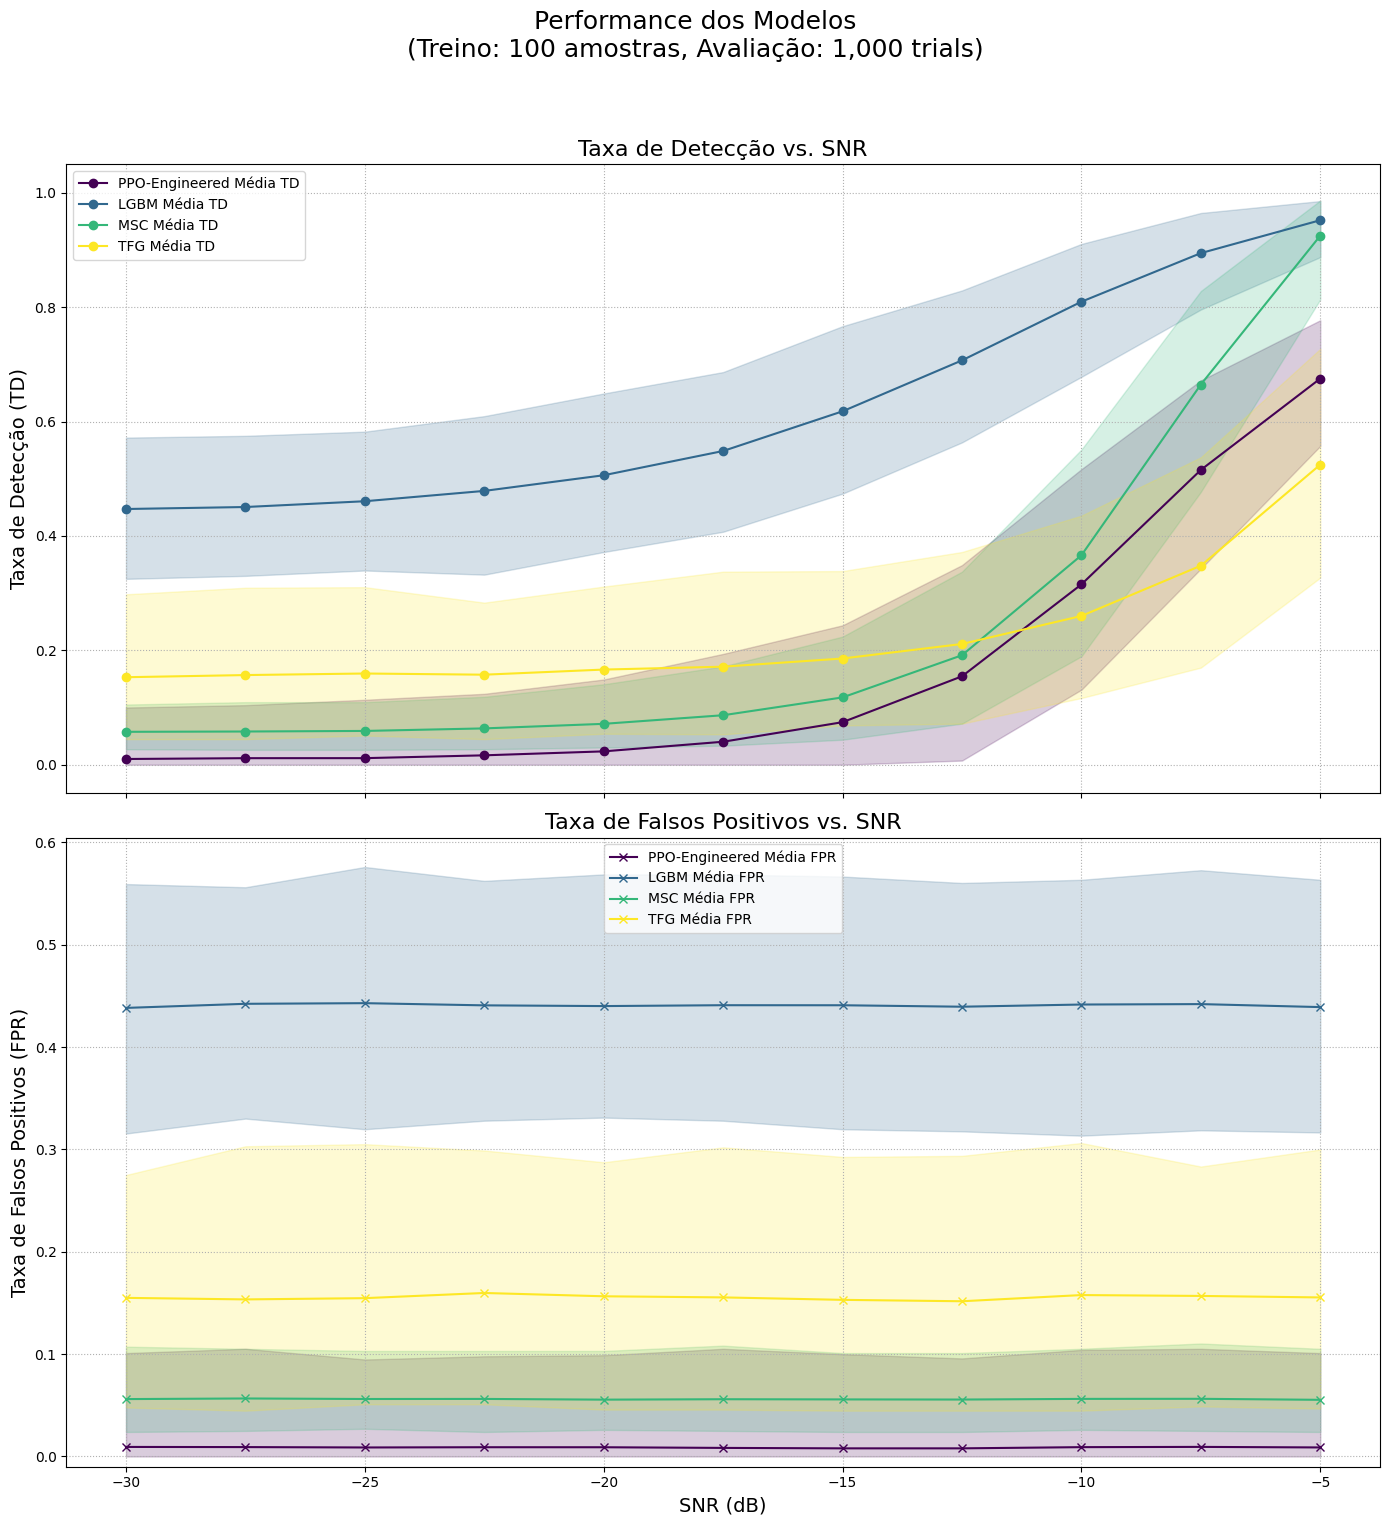

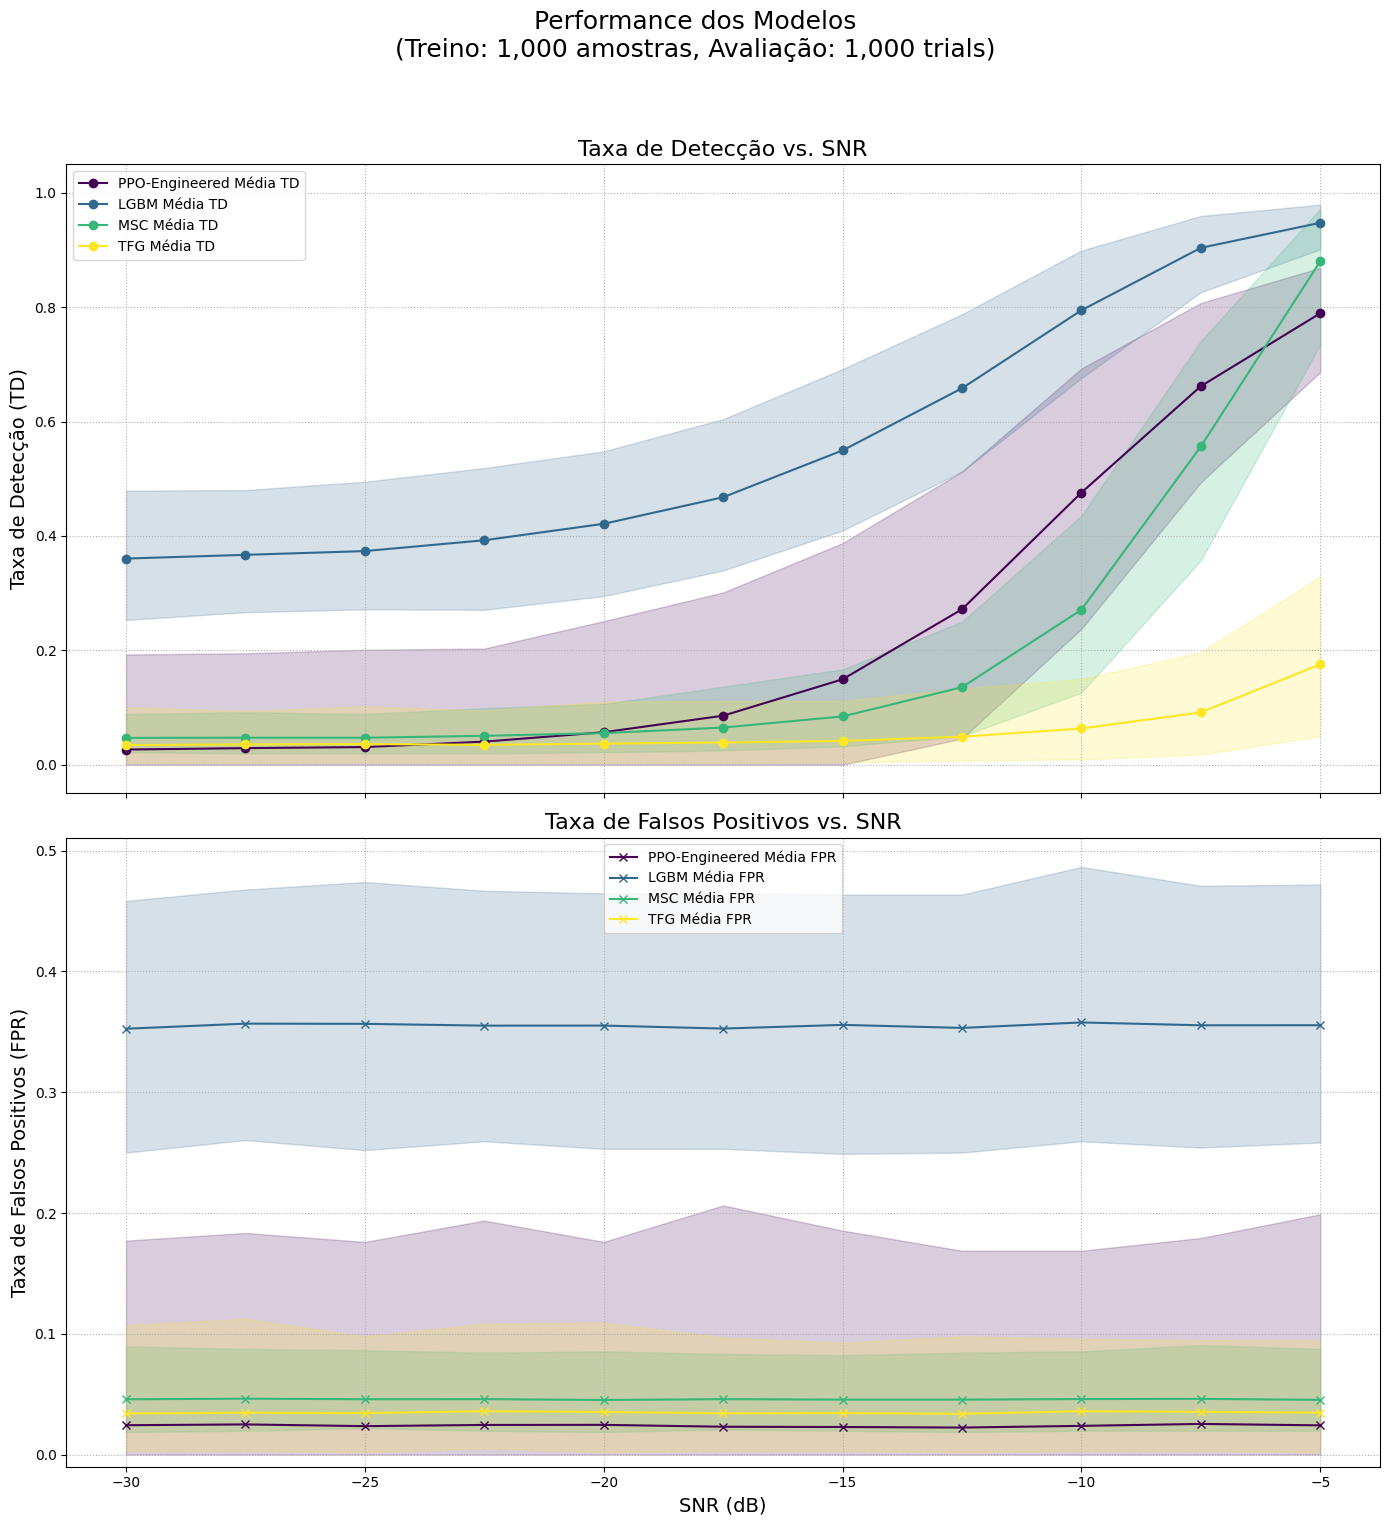

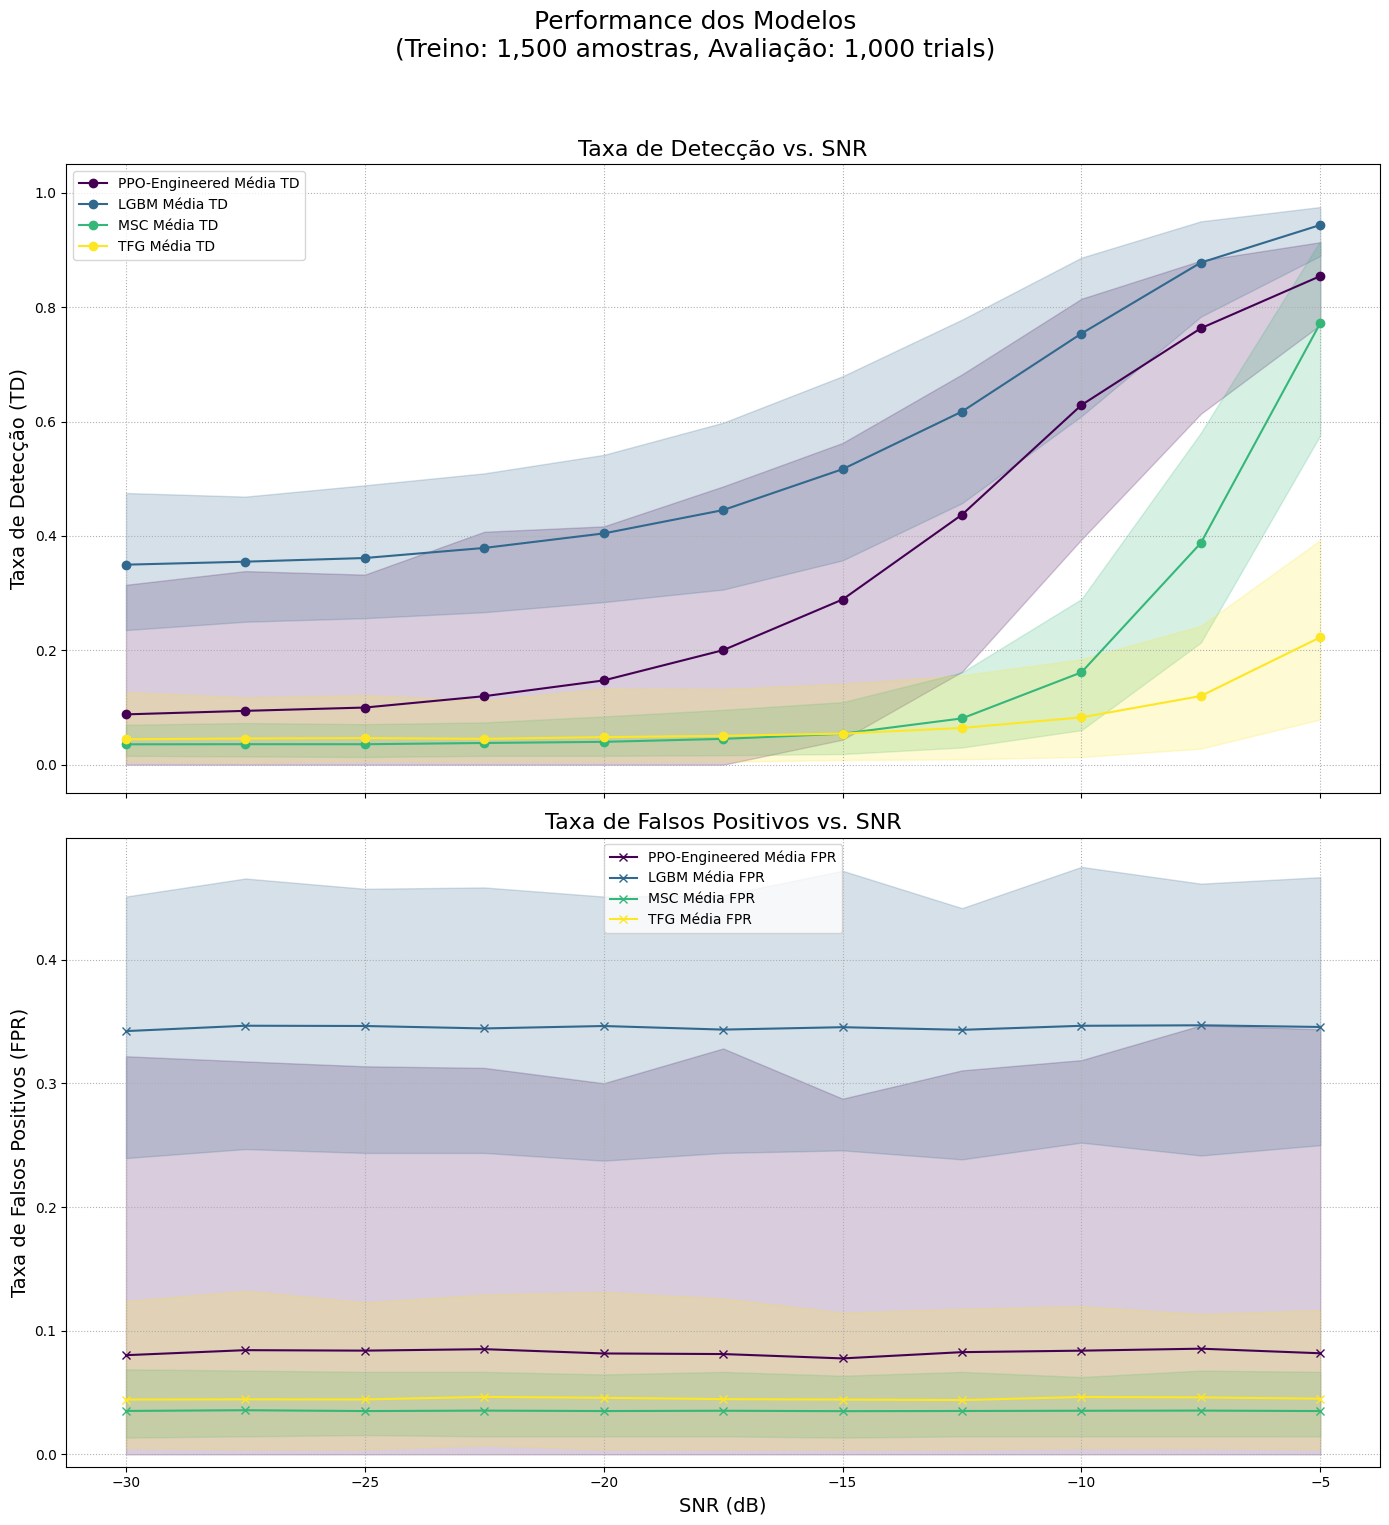



--- STARTING PHASE 2: RETRAINING AND EXPERIMENTAL DATA EVALUATION ---


Cross-Validation Folds:   0%|          | 0/11 [00:00<?, ?it/s]


--- Fold: Using 'Ab' for retraining ---
  Evaluating model: PPO-Engineered


ValueError: not enough values to unpack (expected 4, got 3)

In [1]:
# CODE A (ADAPTED & OPTIMIZED with New Rewards and Experimental Validation)
"""
Full script for large-scale, iterative training and performance evaluation of detectors.

V6 - STATISTICAL REWARD & EXPERIMENTAL VALIDATION
This version introduces a more sophisticated reward mechanism for the PPO agent,
basing the reward on TPR, FPR, and FPR variance over a moving window. It also adds
a second phase for experimental validation, evaluating the models' performance
before and after retraining on out-of-distribution experimental data.
"""

# %% 1. Imports and Configuration
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from tqdm import tqdm
import math
import os
import pickle
from collections import deque

# Ignore specific warnings to keep output clean
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
warnings.filterwarnings("ignore", category=UserWarning, message="Starting from version 2.2.1")
warnings.filterwarnings("ignore", category=FutureWarning)


# ##############################################################################
# SECTION 1: USER-DEFINED PARAMETERS & CONFIGURATION
# ##############################################################################

# --- Experiment Control Parameters ---
TRAINING_SAMPLE_STOPS = [100, 1000, 1500]
EVAL_TRIAL_STOPS = [1000]

# --- Model Training Parameters ---
MODELS_TO_TRAIN_AND_EVAL = ['PPO-Engineered', 'LGBM', 'MSC', 'TFG']
RL_TRAINING_EPOCHS = 10
LGBM_N_ESTIMATORS = 100
REWARD_WINDOW_SIZE = 18  # Window for calculating TPR/FPR based reward

# --- Data and Path Configuration ---
HDF5_TRAIN_FILEPATH = '../data/train_v4.hdf5'
HDF5_EVAL_FILEPATH = '../data/train_v4.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features.hdf5' # For Phase 2
MODELS_DIR = './models' # For saving models for Phase 2

# --- Signal and Feature Configuration ---
NUM_SIGNAL_FREQS = 8
ALL_SNRS = [-30.0, -27.5, -25.0, -22.5, -20.0, -17.5, -15.0, -12.5, -10.0, -7.5, -5.0]
RAW_FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']
MAX_EVAL_TRIALS_PER_SNR = max(EVAL_TRIAL_STOPS)

# ##############################################################################
# FEATURE ENGINEERING CONFIGURATION
# ##############################################################################
FEATURE_CONFIG = [
    # --- Simple Features (current value) ---
    ('MSC', 'simple', {}),
    ('CSM', 'simple', {}),
    ('TFL', 'simple', {}),
    ('SNR_meas', 'simple', {}),
    ('MAG_freq', 'simple', {}),

    # --- Moving Average Features ---
    ('MSC', 'moving_mean', {'window_size': 18}),
    ('CSM', 'moving_mean', {'window_size': 18}),
    ('TFL', 'moving_mean', {'window_size': 18}),

    # --- Cumulative Sum Features ---
    ('MSC', 'cumsum', {}),
    ('CSM', 'cumsum', {}),

    # --- Time-based Feature ---
    ('timestamp', 'simple', {})
]
print(f"PPO model will use {len(FEATURE_CONFIG)} engineered features.")
# ##############################################################################

print(f"Training stops (samples): {TRAINING_SAMPLE_STOPS}")
print(f"Evaluation stops (trials/SNR): {EVAL_TRIAL_STOPS}")
print(f"Models to evaluate: {MODELS_TO_TRAIN_AND_EVAL}")


# ##############################################################################
# SECTION 2: DATA LOADING AND PREPARATION FUNCTIONS (Unchanged)
# ##############################################################################

def my_norm(val, min_val=0, max_val=3):
    """Normalizes a value."""
    return (val - min_val) / (max_val - min_val) if max_val != min_val else 0.0

def generate_features_from_config_vectorized(data_4d, feature_names, config):
    """
    Generates engineered features using vectorized NumPy operations for high performance.
    Shape: (trials, windows, freqs, features) -> (trials, windows, freqs, engineered_features)
    """
    num_trials, num_windows, num_freqs, _ = data_4d.shape
    feature_indices = {name: i for i, name in enumerate(feature_names)}
    
    engineered_features_list = []

    for feature, transform, params in config:
        if feature == 'timestamp':
            ts = (np.arange(1, num_windows + 1) / num_windows).astype(np.float32)
            engineered_feature = np.tile(ts.reshape(1, -1, 1, 1), (num_trials, 1, num_freqs, 1))
            engineered_features_list.append(engineered_feature)
            continue
            
        feature_idx = feature_indices[feature]
        data_slice = data_4d[:, :, :, feature_idx]

        if transform == 'simple':
            engineered_feature = data_slice
            
        elif transform == 'cumsum':
            engineered_feature = np.cumsum(data_slice, axis=1)

        elif transform == 'cummean':
            cumulative_sum = np.cumsum(data_slice, axis=1)
            divisors = np.arange(1, num_windows + 1).reshape(1, -1, 1)
            engineered_feature = cumulative_sum / divisors

        elif transform == 'moving_mean':
            window_size = params.get('window_size', 10)
            reshaped_data = data_slice.transpose(0, 2, 1).reshape(-1, num_windows)
            df = pd.DataFrame(reshaped_data.T)
            rolling_mean_df = df.rolling(window=window_size, min_periods=1).mean()
            rolling_mean_T = rolling_mean_df.to_numpy().T
            engineered_feature = rolling_mean_T.reshape(num_trials, num_freqs, num_windows).transpose(0, 2, 1)

        else:
            raise ValueError(f"Unknown transformation: {transform}")
        
        engineered_features_list.append(my_norm(engineered_feature[..., np.newaxis]))

    return np.concatenate(engineered_features_list, axis=-1, dtype=np.float32)

def load_training_data_for_stage(filepath, snr_levels, total_samples_needed, num_signal_freqs):
    """
    Loads and prepares a specific number of training samples from 4D HDF5 data.
    Generates raw features for standard models and engineered features for PPO.
    """
    X_all_snrs_4d = []
    
    with h5py.File(filepath, 'r') as f:
        first_key = f"snr_{snr_levels[0]:.1f}"
        if first_key not in f:
                raise ValueError(f"Initial SNR key {first_key} not found in HDF5 file.")
        _, windows_per_trial, freqs_per_trial, _ = f[first_key]['metrics'].shape
        samples_per_trial = windows_per_trial * freqs_per_trial

    samples_per_snr = math.ceil(total_samples_needed / len(snr_levels))
    trials_per_snr = math.ceil(samples_per_snr / samples_per_trial)
    
    print(f"Loading up to {trials_per_snr} trials per SNR to gather enough samples.")
    
    with h5py.File(filepath, 'r') as f:
        for snr in snr_levels:
            key = f"snr_{snr:.1f}"
            if key in f:
                metrics_data_4d = f[key]['metrics'][:trials_per_snr, ...]
                X_all_snrs_4d.append(metrics_data_4d)
            else:
                print(f"Warning: Training SNR {snr} not found in {filepath}")

    if not X_all_snrs_4d:
        return None

    X_full_4d = np.vstack(X_all_snrs_4d)
    
    num_trials, num_windows, num_freqs, num_raw_features = X_full_4d.shape

    freq_labels = np.zeros(num_freqs)
    freq_labels[:num_signal_freqs] = 1
    y_labels_4d = np.tile(freq_labels, (num_trials, num_windows, 1))

    X_flat = X_full_4d.reshape(-1, num_raw_features)
    y_flat = y_labels_4d.flatten()

    p = np.random.permutation(len(X_flat))
    X_flat_shuffled = X_flat[p]
    y_flat_shuffled = y_flat[p]
    
    samples_to_take = min(total_samples_needed, len(X_flat_shuffled))
    X_train_flat = X_flat_shuffled[:samples_to_take]
    y_train_flat = y_flat_shuffled[:samples_to_take]
    
    print("Calculating engineered features for PPO model...")
    X_engineered_4d = generate_features_from_config_vectorized(X_full_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
    _, _, _, num_engineered_features = X_engineered_4d.shape
    X_engineered_flat = X_engineered_4d.reshape(-1, num_engineered_features)
    
    X_train_engineered = X_engineered_flat[p][:samples_to_take]

    return {
        'flat': (X_train_flat, y_train_flat),
        'engineered': (X_train_engineered, y_train_flat)
    }

def load_evaluation_data_for_snr(filepath, snr, trials_per_snr, num_signal_freqs):
    try:
        with h5py.File(filepath, 'r') as f:
            key = f"snr_{snr:.1f}"
            if key not in f:
                return np.array([]), np.array([])
            
            metrics_data_4d = f[key]['metrics'][:trials_per_snr, ...]

        signal_data_4d = metrics_data_4d[:, :, :num_signal_freqs, :]
        noise_data_4d = metrics_data_4d[:, :, num_signal_freqs:, :]
        
        return signal_data_4d, noise_data_4d
    except Exception as e:
        print(f"Error loading evaluation data for SNR {snr}: {e}")
        return np.array([]), np.array([])


# ##############################################################################
# SECTION 3: MODELS, ENVIRONMENT, AND HELPER FUNCTIONS (REWARD ENV MODIFIED)
# ##############################################################################

class SignalDetectionEnvWithStats(gym.Env):
    """
    A Gym environment for signal detection that provides rewards based on
    TPR, FPR, and FPR variance calculated over a moving window of recent decisions.
    """
    def __init__(self, features, labels, window_size=18):
        super().__init__()
        self.features = features
        self.labels = labels
        self.window_size = window_size
        self.history = deque(maxlen=self.window_size)
        self.current_step = 0
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)

    def step(self, action):
        predicted_label = 1 if action[0] > 0 else 0
        true_label = self.labels[self.current_step]
        
        self.history.append((predicted_label, true_label))
        
        # Calculate reward based on the history
        if len(self.history) < self.window_size:
            # Provide a simple, immediate reward until the window is full
            reward = 1.0 if predicted_label == true_label else -1.0
        else:
            hist_preds = np.array([h[0] for h in self.history])
            hist_labels = np.array([h[1] for h in self.history])
            
            # True Positives, False Positives
            tp = np.sum((hist_preds == 1) & (hist_labels == 1))
            fp = np.sum((hist_preds == 1) & (hist_labels == 0))
            
            # Total actual positives and negatives
            actual_pos = np.sum(hist_labels == 1)
            actual_neg = np.sum(hist_labels == 0)
            
            tpr = tp / actual_pos if actual_pos > 0 else 0
            fpr = fp / actual_neg if actual_neg > 0 else 0
            
            # Variance of FPR (variance of predictions on negative samples)
            fpr_decisions = hist_preds[hist_labels == 0]
            fpr_var = np.var(fpr_decisions) if len(fpr_decisions) > 1 else 0
            
            reward = tpr - fpr - fpr_var

        self.current_step += 1
        terminated = self.current_step >= len(self.features)
        next_obs = self.features[self.current_step] if not terminated else np.zeros(self.observation_space.shape)
        
        return next_obs, reward, terminated, False, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.history.clear()
        return self.features[0], {}

class ORDTester:
    def __init__(self, desired_alpha=0.05, feature_names=RAW_FEATURE_NAMES):
        self.desired_alpha = desired_alpha
        self.feature_names = feature_names
        self.thresholds = {}
    def train(self, noise_features):
        for i, key in enumerate(self.feature_names):
            if noise_features.shape[0] > 0:
                self.thresholds[key] = np.percentile(noise_features[:, i], (1 - self.desired_alpha) * 100)
    def predict(self, features):
        decisions = {}
        for i, name in enumerate(self.feature_names):
            if name in self.thresholds:
                decisions[name] = (features[:, i] > self.thresholds[name]).astype(int)
            else:
                decisions[name] = np.zeros(features.shape[0], dtype=int)
        return decisions

def predict_lgbm(model, features_flat): return model.predict(features_flat)

def predict_ppo(model, features_flat):
    preds, _ = model.predict(features_flat, deterministic=True)
    preds[np.isnan(preds)] = 0
    return (preds > 0).astype(int)

def predict_statistical(model, features_flat, detector_name):
    decisions = model.predict(features_flat)
    return decisions.get(detector_name, np.zeros(features_flat.shape[0], dtype=int))

def calculate_statistics(predictions_per_trial):
    per_trial_metric = np.mean(predictions_per_trial, axis=1)
    return {
        'mean': np.mean(per_trial_metric),
        'variance': np.var(per_trial_metric),
        'p1': np.percentile(per_trial_metric, 1),
        'p99': np.percentile(per_trial_metric, 99)
    }

# ##############################################################################
# SECTION 4: MAIN EXPERIMENT AND ANALYSIS LOOP
# ##############################################################################
def run_full_experiment():
    """Main function to run the entire training and evaluation pipeline."""
    all_results_over_time = []
    policy_kwargs = dict(net_arch=dict(pi=[64, 64], vf=[64, 64]))
    CHECKPOINT_TRAINING_SIZE = max(TRAINING_SAMPLE_STOPS)

    for training_size in tqdm(TRAINING_SAMPLE_STOPS, desc="Total Experiment Progress"):
        print(f"\n{'='*80}\nSTARTING STAGE: {training_size:,} samples\n{'='*80}")
        
        print(f"Loading {training_size:,} samples for training...")
        current_train_datasets = load_training_data_for_stage(
            HDF5_TRAIN_FILEPATH, ALL_SNRS, training_size, NUM_SIGNAL_FREQS
        )
        
        if current_train_datasets is None:
            print(f"Could not load data for training size {training_size}. Skipping stage.")
            continue
            
        print("Data loaded. Starting model training...")
        X_train_flat_slice, y_train_flat_slice = current_train_datasets['flat']
        X_train_engineered_slice, y_train_engineered_slice = current_train_datasets['engineered']

        trained_models_step = {}
        
        # --- Model Training Phase ---
        if 'LGBM' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training LGBM...")
            model_lgbm = lgb.LGBMClassifier(n_estimators=LGBM_N_ESTIMATORS, random_state=42, verbosity=-1)
            model_lgbm.fit(X_train_flat_slice, y_train_flat_slice)
            trained_models_step['LGBM'] = model_lgbm

        if 'PPO-Engineered' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training PPO-Engineered with statistical reward...")
            # MODIFICATION: Use the new environment with statistical rewards
            env = SignalDetectionEnvWithStats(X_train_engineered_slice, y_train_engineered_slice, window_size=REWARD_WINDOW_SIZE)
            total_timesteps = len(X_train_engineered_slice) * RL_TRAINING_EPOCHS
            model_ppo = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, n_steps=min(2048, len(X_train_engineered_slice)), verbose=0)
            model_ppo.learn(total_timesteps=total_timesteps)
            trained_models_step['PPO-Engineered'] = model_ppo

        if 'MSC' in MODELS_TO_TRAIN_AND_EVAL or 'TFG' in MODELS_TO_TRAIN_AND_EVAL:
            print("Training Statistical Detectors (ORD)...")
            ord_tester = ORDTester(feature_names=RAW_FEATURE_NAMES)
            ord_tester.train(X_train_flat_slice[y_train_flat_slice == 0])
            trained_models_step['MSC'] = ord_tester
            trained_models_step['TFG'] = ord_tester
        
        # --- Save models from the final training stage for experimental validation ---
        if training_size == CHECKPOINT_TRAINING_SIZE:
            print(f"\nSaving models trained on {training_size} samples for Phase 2...")
            os.makedirs(MODELS_DIR, exist_ok=True)
            for model_name, model in trained_models_step.items():
                if model_name == 'PPO-Engineered':
                    model.save(os.path.join(MODELS_DIR, f'{model_name}_{training_size}_samples.zip'))
                else:
                    with open(os.path.join(MODELS_DIR, f'{model_name}_{training_size}_samples.pkl'), 'wb') as f:
                        pickle.dump(model, f)
            print("Models saved.")

        print(f"\n--- Starting Evaluation for models trained with {training_size:,} samples ---")
        
        # --- Evaluation Phase ---
        for eval_trials in tqdm(EVAL_TRIAL_STOPS, desc="Evaluation Stages", leave=False):
            for snr in tqdm(ALL_SNRS, desc=f"Evaluating SNRs (using {eval_trials} trials)", leave=False):
                signal_data_4d, noise_data_4d = load_evaluation_data_for_snr(
                    HDF5_EVAL_FILEPATH, snr, eval_trials, NUM_SIGNAL_FREQS
                )
                
                if signal_data_4d.size == 0 or noise_data_4d.size == 0: continue
                
                num_signal_trials, _, _, n_raw_features = signal_data_4d.shape
                num_noise_trials, _, _, _ = noise_data_4d.shape

                for model_name, model in trained_models_step.items():
                    if model_name == 'PPO-Engineered':
                        engineered_signal_4d = generate_features_from_config_vectorized(signal_data_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
                        engineered_noise_4d = generate_features_from_config_vectorized(noise_data_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
                        
                        _, _, _, n_engineered_features = engineered_signal_4d.shape
                        
                        features_pd = engineered_signal_4d.reshape(-1, n_engineered_features)
                        features_fpr = engineered_noise_4d.reshape(-1, n_engineered_features)
                        
                        preds_pd = predict_ppo(model, features_pd)
                        preds_fpr = predict_ppo(model, features_fpr)
                    else:
                        features_pd = signal_data_4d.reshape(-1, n_raw_features)
                        features_fpr = noise_data_4d.reshape(-1, n_raw_features)
                        
                        if model_name == 'LGBM':
                            preds_pd = predict_lgbm(model, features_pd)
                            preds_fpr = predict_lgbm(model, features_fpr)
                        elif model_name in ['MSC', 'TFG']:
                            preds_pd = predict_statistical(model, features_pd, model_name)
                            preds_fpr = predict_statistical(model, features_fpr, model_name)
                    
                    td_stats = calculate_statistics(preds_pd.reshape(num_signal_trials, -1))
                    fpr_stats = calculate_statistics(preds_fpr.reshape(num_noise_trials, -1))

                    all_results_over_time.append({'Amostras Treino': training_size, 'Trials Avaliação': eval_trials, 'Modelo': model_name, 'Métrica': 'TD', 'SNR': snr, 'Média': td_stats['mean'], 'Variância': td_stats['variance'], 'P1': td_stats['p1'], 'P99': td_stats['p99']})
                    all_results_over_time.append({'Amostras Treino': training_size, 'Trials Avaliação': eval_trials, 'Modelo': model_name, 'Métrica': 'FPR', 'SNR': snr, 'Média': fpr_stats['mean'], 'Variância': fpr_stats['variance'], 'P1': fpr_stats['p1'], 'P99': fpr_stats['p99']})
    
    print("\n\n--- SIMULATION EXPERIMENT COMPLETED ---")
    return pd.DataFrame(all_results_over_time)

# ##############################################################################
# SECTION 5: FINAL PLOTTING AND VISUALIZATION (Unchanged)
# ##############################################################################

def plot_performance_curves_with_ci(df, training_stop, eval_stop):
    """Plots TD and FPR vs. SNR curves with 98% confidence intervals."""
    df_plot = df[(df['Amostras Treino'] == training_stop) & (df['Trials Avaliação'] == eval_stop)]
    
    if df_plot.empty:
        print(f"\nWarning: No evaluation data found for {training_stop} training samples and {eval_stop} eval trials.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16), sharex=True)
    title = (f'Performance dos Modelos\n'
             f'(Treino: {training_stop:,.0f} amostras, Avaliação: {eval_stop:,.0f} trials)')
    fig.suptitle(title, fontsize=18)

    colors = plt.cm.viridis(np.linspace(0, 1, len(MODELS_TO_TRAIN_AND_EVAL)))
    model_colors = {model: color for model, color in zip(MODELS_TO_TRAIN_AND_EVAL, colors)}

    for model in MODELS_TO_TRAIN_AND_EVAL:
        model_data = df_plot[(df_plot['Modelo'] == model) & (df_plot['Métrica'] == 'TD')].sort_values('SNR')
        if not model_data.empty:
            ax1.plot(model_data['SNR'], model_data['Média'], label=f'{model} Média TD', color=model_colors[model], marker='o')
            ax1.fill_between(model_data['SNR'], model_data['P1'], model_data['P99'], color=model_colors[model], alpha=0.2)
    ax1.set_ylabel('Taxa de Detecção (TD)', fontsize=14)
    ax1.set_title('Taxa de Detecção vs. SNR', fontsize=16)
    ax1.grid(True, which='both', linestyle=':')
    ax1.legend()
    ax1.set_ylim(-0.05, 1.05)

    for model in MODELS_TO_TRAIN_AND_EVAL:
        model_data = df_plot[(df_plot['Modelo'] == model) & (df_plot['Métrica'] == 'FPR')].sort_values('SNR')
        if not model_data.empty:
            ax2.plot(model_data['SNR'], model_data['Média'], label=f'{model} Média FPR', color=model_colors[model], marker='x')
            ax2.fill_between(model_data['SNR'], model_data['P1'], model_data['P99'], color=model_colors[model], alpha=0.2)
    ax2.set_xlabel('SNR (dB)', fontsize=14)
    ax2.set_ylabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    ax2.set_title('Taxa de Falsos Positivos vs. SNR', fontsize=16)
    ax2.grid(True, which='both', linestyle=':')
    ax2.legend()
    ax2.set_ylim(bottom=-0.01)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ##############################################################################
# SECTION 6: EXPERIMENTAL VALIDATION (NEW)
# ##############################################################################
def run_experimental_validation():
    """
    Phase 2: Evaluates models on experimental data using leave-one-out cross
    -validation. Compares baseline performance with performance after retraining.
    """
    print(f"\n\n{'='*80}\n--- STARTING PHASE 2: RETRAINING AND EXPERIMENTAL DATA EVALUATION ---\n{'='*80}")
    
    CHECKPOINT_TRAINING_SIZE = max(TRAINING_SAMPLE_STOPS)

    if not os.path.exists(EXPERIMENTAL_FEATURES_FILE):
        print(f"WARNING: Experimental data file '{EXPERIMENTAL_FEATURES_FILE}' not found. Skipping Phase 2.")
        return

    with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
        volunteers = list(f.keys())
    
    results = {model: {k:[] for k in ['baseline_tpr','baseline_fpr','retrain_tpr','retrain_fpr']} for model in MODELS_TO_TRAIN_AND_EVAL}

    def evaluate_on_experimental(model, X_raw_4d, model_name):
        """Helper to evaluate any model on the 4D experimental data."""
        num_trials, _, num_total_freqs, _ = X_raw_4d.shape

        if model_name == 'PPO-Engineered':
            X_engineered = generate_features_from_config_vectorized(X_raw_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
            _, _, _, n_features = X_engineered.shape
            features_flat = X_engineered.reshape(-1, n_features)
            preds = predict_ppo(model, features_flat)
        else: # LGBM and Statistical
            _, _, _, n_features = X_raw_4d.shape
            features_flat = X_raw_4d.reshape(-1, n_features)
            if model_name == 'LGBM':
                preds = predict_lgbm(model, features_flat)
            else: # MSC, TFG
                preds = predict_statistical(model, features_flat, model_name)
        
        preds_reshaped = preds.reshape(num_trials, -1)
        # Assumes the first NUM_SIGNAL_FREQS are signal, the rest are noise
        tpr = np.mean(preds_reshaped[:, :NUM_SIGNAL_FREQS])
        fpr = np.mean(preds_reshaped[:, NUM_SIGNAL_FREQS:])
        return tpr, fpr

    for tune_volunteer in tqdm(volunteers, desc="Cross-Validation Folds"):
        print(f"\n--- Fold: Using '{tune_volunteer}' for retraining ---")
        
        # Load data for the current fold
        with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
            X_tune_raw = np.vstack([f[tune_volunteer][intensity]['metrics'][:] for intensity in f[tune_volunteer].keys()])
            X_test_list = []
            test_volunteers = [v for v in volunteers if v != tune_volunteer]
            for v_test in test_volunteers:
                for intensity in f[v_test].keys():
                    X_test_list.append(f[v_test][intensity]['metrics'][:])
        
        if not X_test_list:
            print("  - WARNING: No test data found for this fold. Skipping.")
            continue
        X_test_raw = np.vstack(X_test_list)

        for model_name in MODELS_TO_TRAIN_AND_EVAL:
            # --- 1. Baseline Evaluation ---
            model_path_zip = os.path.join(MODELS_DIR, f'{model_name}_{CHECKPOINT_TRAINING_SIZE}_samples.zip')
            model_path_pkl = os.path.join(MODELS_DIR, f'{model_name}_{CHECKPOINT_TRAINING_SIZE}_samples.pkl')
            
            base_model = None
            try:
                if os.path.exists(model_path_zip): # SB3 models
                    base_model = PPO.load(model_path_zip)
                elif os.path.exists(model_path_pkl): # Other models
                    with open(model_path_pkl, 'rb') as f:
                        base_model = pickle.load(f)
                else:
                    print(f"  - WARNING: Pre-trained model for {model_name} not found. Skipping.")
                    continue
            except Exception as e:
                print(f"  - ERROR loading model {model_name}: {e}. Skipping.")
                continue

            print(f"  Evaluating model: {model_name}")
            tpr_base, fpr_base = evaluate_on_experimental(base_model, X_test_raw, model_name)
            results[model_name]['baseline_tpr'].append(tpr_base)
            results[model_name]['baseline_fpr'].append(fpr_base)
            print(f"    - Baseline : TPR={100*tpr_base:.3f}%, FPR={100*fpr_base:.3f}%")

            # --- 2. Retraining and Evaluation ---
            # Prepare tuning data labels
            num_tune_trials, _, num_freqs, _ = X_tune_raw.shape
            y_tune_labels_single_trial = np.concatenate([np.ones(NUM_SIGNAL_FREQS), np.zeros(num_freqs - NUM_SIGNAL_FREQS)])
            y_tune_flat = np.tile(y_tune_labels_single_trial, num_tune_trials * X_tune_raw.shape[1])
            
            re_model = None
            if model_name == 'PPO-Engineered':
                X_tune_engineered = generate_features_from_config_vectorized(X_tune_raw, RAW_FEATURE_NAMES, FEATURE_CONFIG)
                _,_,_,n_eng_feats = X_tune_engineered.shape
                X_tune_eng_flat = X_tune_engineered.reshape(-1, n_eng_feats)
                
                env = SignalDetectionEnvWithStats(X_tune_eng_flat, y_tune_flat, window_size=REWARD_WINDOW_SIZE)
                re_model = PPO("MlpPolicy", env, n_steps=min(1024, len(X_tune_eng_flat)), verbose=0)
                re_model.learn(total_timesteps=len(X_tune_eng_flat)) # Short retraining
            
            elif model_name == 'LGBM':
                _,_,_,n_raw_feats = X_tune_raw.shape
                X_tune_flat = X_tune_raw.reshape(-1, n_raw_feats)
                re_model = lgb.LGBMClassifier(n_estimators=LGBM_N_ESTIMATORS, random_state=42, verbosity=-1)
                re_model.fit(X_tune_flat, y_tune_flat)

            elif model_name in ['MSC', 'TFG']:
                _,_,_,n_raw_feats = X_tune_raw.shape
                X_tune_flat = X_tune_raw.reshape(-1, n_raw_feats)
                re_model = ORDTester(feature_names=RAW_FEATURE_NAMES)
                re_model.train(X_tune_flat[y_tune_flat == 0])

            if re_model:
                tpr_re, fpr_re = evaluate_on_experimental(re_model, X_test_raw, model_name)
                results[model_name]['retrain_tpr'].append(tpr_re)
                results[model_name]['retrain_fpr'].append(fpr_re)
                print(f"    - Retrained: TPR={100*tpr_re:.3f}%, FPR={100*fpr_re:.3f}%")

    # --- Print Final Experimental Results ---
    print("\n\n--- FINAL EXPERIMENTAL RESULTS (MEAN +/- STD DEV) ---")
    for model_name in MODELS_TO_TRAIN_AND_EVAL:
        print(f"\nResults for: {model_name}")
        for approach in ['baseline', 'retrain']:
            tpr_mean = np.mean(results[model_name][f'{approach}_tpr'])
            tpr_std = np.std(results[model_name][f'{approach}_tpr'])
            fpr_mean = np.mean(results[model_name][f'{approach}_fpr'])
            fpr_std = np.std(results[model_name][f'{approach}_fpr'])
            if not np.isnan(tpr_mean):
                print(f"  {approach.capitalize():<10}: TPR = {tpr_mean:.3f} ± {tpr_std:.3f} | FPR = {fpr_mean:.3f} ± {fpr_std:.3f}")

# ##############################################################################
# SECTION 7: SCRIPT EXECUTION
# ##############################################################################

if __name__ == '__main__':
    # --- PHASE 1: Training on simulated data and plotting performance ---
    final_df = run_full_experiment()

    if not final_df.empty:
        print("\n\n--- Final Analysis & Visualization ---")
        
        snr_for_analysis = -10.0
        print(f"\n--- Evolution of Mean TD (at SNR={snr_for_analysis}dB) vs. Training Samples ---")
        pivot_td = final_df[
            (final_df['Métrica'] == 'TD') & 
            (final_df['SNR'] == snr_for_analysis)
        ].pivot_table(
            index='Amostras Treino', columns='Modelo', values='Média'
        )
        print(pivot_td.to_string())

        print("\n\n--- Generating Performance Plots for Each Training Stage ---")
        for train_stop in TRAINING_SAMPLE_STOPS:
            plot_performance_curves_with_ci(final_df, train_stop, max(EVAL_TRIAL_STOPS))
    else:
        print("\nExperiment (Phase 1) finished, but no results were generated to plot.")

    # --- PHASE 2: Validation on experimental data ---
    run_experimental_validation()

In [4]:
# ##############################################################################
# SECTION 6: EXPERIMENTAL VALIDATION (FIXED)
# ##############################################################################
def run_experimental_validation():
    """
    Phase 2: Evaluates models on experimental data using leave-one-out cross
    -validation. Compares baseline performance with performance after retraining.
    """
    print(f"\n\n{'='*80}\n--- STARTING PHASE 2: RETRAINING AND EXPERIMENTAL DATA EVALUATION ---\n{'='*80}")
    
    CHECKPOINT_TRAINING_SIZE = max(TRAINING_SAMPLE_STOPS)

    if not os.path.exists(EXPERIMENTAL_FEATURES_FILE):
        print(f"WARNING: Experimental data file '{EXPERIMENTAL_FEATURES_FILE}' not found. Skipping Phase 2.")
        return

    with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
        volunteers = list(f.keys())
    
    results = {model: {k:[] for k in ['baseline_tpr','baseline_fpr','retrain_tpr','retrain_fpr']} for model in MODELS_TO_TRAIN_AND_EVAL}

    # ========================================================================
    # START OF FIX: This helper function is corrected
    # ========================================================================
    def evaluate_on_experimental(model, X_raw, model_name):
        """
        Helper to evaluate any model on the experimental data, handling both
        3D and 4D input shapes and correctly calculating TPR/FPR.
        """
        # FIX 1: Reshape 3D input to 4D to match (trials, windows, freqs, features) format
        if X_raw.ndim == 3:
            # Treat the entire block of data as a single trial
            X_raw_4d = X_raw[np.newaxis, ...] 
        else:
            # Assumes data is already in 4D format
            X_raw_4d = X_raw

        # Unpack the now-guaranteed 4D shape
        num_trials, num_windows, num_total_freqs, _ = X_raw_4d.shape

        # --- Generate features and predict ---
        if model_name == 'PPO-Engineered':
            X_engineered = generate_features_from_config_vectorized(X_raw_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
            _, _, _, n_features = X_engineered.shape
            features_flat = X_engineered.reshape(-1, n_features)
            preds = predict_ppo(model, features_flat)
        else: # LGBM and Statistical
            _, _, _, n_features = X_raw_4d.shape
            features_flat = X_raw_4d.reshape(-1, n_features)
            if model_name == 'LGBM':
                preds = predict_lgbm(model, features_flat)
            else: # MSC, TFG
                preds = predict_statistical(model, features_flat, model_name)
        
        # FIX 2: Correctly reshape predictions and calculate TPR/FPR
        # Reshape the flat prediction array back to its original logical structure
        preds_structured = preds.reshape(num_trials, num_windows, num_total_freqs)
        
        # Slice along the frequency axis to separate signal and noise predictions
        signal_frequency_preds = preds_structured[:, :, :NUM_SIGNAL_FREQS]
        noise_frequency_preds = preds_structured[:, :, NUM_SIGNAL_FREQS:]
        
        # Calculate TPR and FPR by taking the mean of the relevant predictions
        tpr = np.mean(signal_frequency_preds)
        fpr = np.mean(noise_frequency_preds)
        
        return tpr, fpr
    # ========================================================================
    # END OF FIX
    # ========================================================================

    for tune_volunteer in tqdm(volunteers, desc="Cross-Validation Folds"):
        print(f"\n--- Fold: Using '{tune_volunteer}' for retraining ---")
        
        # Load data for the current fold
        with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
            X_tune_raw = np.vstack([f[tune_volunteer][intensity]['metrics'][:] for intensity in f[tune_volunteer].keys()])
            X_test_list = []
            test_volunteers = [v for v in volunteers if v != tune_volunteer]
            for v_test in test_volunteers:
                for intensity in f[v_test].keys():
                    X_test_list.append(f[v_test][intensity]['metrics'][:])
        
        if not X_test_list:
            print("  - WARNING: No test data found for this fold. Skipping.")
            continue
        X_test_raw = np.vstack(X_test_list) # This creates a 3D array

        for model_name in MODELS_TO_TRAIN_AND_EVAL:
            # --- 1. Baseline Evaluation ---
            model_path_zip = os.path.join(MODELS_DIR, f'{model_name}_{CHECKPOINT_TRAINING_SIZE}_samples.zip')
            model_path_pkl = os.path.join(MODELS_DIR, f'{model_name}_{CHECKPOINT_TRAINING_SIZE}_samples.pkl')
            
            base_model = None
            try:
                if os.path.exists(model_path_zip): # SB3 models
                    base_model = PPO.load(model_path_zip)
                elif os.path.exists(model_path_pkl): # Other models
                    with open(model_path_pkl, 'rb') as f:
                        base_model = pickle.load(f)
                else:
                    print(f"  - WARNING: Pre-trained model for {model_name} not found. Skipping.")
                    continue
            except Exception as e:
                print(f"  - ERROR loading model {model_name}: {e}. Skipping.")
                continue

            print(f"  Evaluating model: {model_name}")
            # The X_test_raw is 3D, but the fixed function handles it correctly
            tpr_base, fpr_base = evaluate_on_experimental(base_model, X_test_raw, model_name)
            results[model_name]['baseline_tpr'].append(tpr_base)
            results[model_name]['baseline_fpr'].append(fpr_base)
            print(f"    - Baseline : TPR={100*tpr_base:.3f}%, FPR={100*fpr_base:.3f}%")

            # --- 2. Retraining and Evaluation ---
            # Prepare tuning data labels
            num_tune_windows, num_freqs, _ = X_tune_raw.shape
            y_tune_labels_single_trial = np.concatenate([np.ones(NUM_SIGNAL_FREQS), np.zeros(num_freqs - NUM_SIGNAL_FREQS)])
            y_tune_flat = np.tile(y_tune_labels_single_trial, num_tune_windows)
            
            re_model = None
            if model_name == 'PPO-Engineered':
                # For PPO, we need to add the "trial" dimension before feature generation
                X_tune_raw_4d = X_tune_raw[np.newaxis, ...]
                X_tune_engineered = generate_features_from_config_vectorized(X_tune_raw_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
                _,_,_,n_eng_feats = X_tune_engineered.shape
                X_tune_eng_flat = X_tune_engineered.reshape(-1, n_eng_feats)
                
                env = SignalDetectionEnvWithStats(X_tune_eng_flat, y_tune_flat, window_size=REWARD_WINDOW_SIZE)
                re_model = PPO("MlpPolicy", env, n_steps=min(1024, len(X_tune_eng_flat)), verbose=0)
                re_model.learn(total_timesteps=len(X_tune_eng_flat)) # Short retraining
            
            elif model_name == 'LGBM':
                _,_,n_raw_feats = X_tune_raw.shape
                X_tune_flat = X_tune_raw.reshape(-1, n_raw_feats)
                re_model = lgb.LGBMClassifier(n_estimators=LGBM_N_ESTIMATORS, random_state=42, verbosity=-1)
                re_model.fit(X_tune_flat, y_tune_flat)

            elif model_name in ['MSC', 'TFG']:
                _,_,n_raw_feats = X_tune_raw.shape
                X_tune_flat = X_tune_raw.reshape(-1, n_raw_feats)
                re_model = ORDTester(feature_names=RAW_FEATURE_NAMES)
                re_model.train(X_tune_flat[y_tune_flat == 0])

            if re_model:
                tpr_re, fpr_re = evaluate_on_experimental(re_model, X_test_raw, model_name)
                results[model_name]['retrain_tpr'].append(tpr_re)
                results[model_name]['retrain_fpr'].append(fpr_re)
                print(f"    - Retrained: TPR={100*tpr_re:.3f}%, FPR={100*fpr_re:.3f}%")

    # --- Print Final Experimental Results ---
    print("\n\n--- FINAL EXPERIMENTAL RESULTS (MEAN +/- STD DEV) ---")
    for model_name in MODELS_TO_TRAIN_AND_EVAL:
        print(f"\nResults for: {model_name}")
        for approach in ['baseline', 'retrain']:
            tpr_mean = np.mean(results[model_name][f'{approach}_tpr'])
            tpr_std = np.std(results[model_name][f'{approach}_tpr'])
            fpr_mean = np.mean(results[model_name][f'{approach}_fpr'])
            fpr_std = np.std(results[model_name][f'{approach}_fpr'])
            if not np.isnan(tpr_mean):
                print(f"  {approach.capitalize():<10}: TPR = {tpr_mean:.3f} ± {tpr_std:.3f} | FPR = {fpr_mean:.3f} ± {fpr_std:.3f}")

run_experimental_validation()



--- STARTING PHASE 2: RETRAINING AND EXPERIMENTAL DATA EVALUATION ---


Cross-Validation Folds:   0%|          | 0/11 [00:00<?, ?it/s]


--- Fold: Using 'Ab' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=30.275%, FPR=15.188%
  Evaluating model: LGBM
    - Baseline : TPR=67.778%, FPR=84.502%


Cross-Validation Folds:   9%|▉         | 1/11 [00:54<09:04, 54.46s/it]

    - Retrained: TPR=99.978%, FPR=0.430%
  Evaluating model: MSC
    - Baseline : TPR=1.716%, FPR=17.710%
    - Retrained: TPR=0.786%, FPR=9.670%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.627%, FPR=1.946%

--- Fold: Using 'An' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=98.630%, FPR=96.643%
  Evaluating model: LGBM
    - Baseline : TPR=67.831%, FPR=84.303%


Cross-Validation Folds:  18%|█▊        | 2/11 [01:47<08:04, 53.89s/it]

    - Retrained: TPR=100.000%, FPR=0.827%
  Evaluating model: MSC
    - Baseline : TPR=1.732%, FPR=19.370%
    - Retrained: TPR=4.446%, FPR=32.042%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.623%, FPR=22.377%

--- Fold: Using 'Bb' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=16.542%, FPR=6.210%
  Evaluating model: LGBM
    - Baseline : TPR=67.686%, FPR=84.739%


Cross-Validation Folds:  27%|██▋       | 3/11 [02:38<06:59, 52.43s/it]

    - Retrained: TPR=99.992%, FPR=0.546%
  Evaluating model: MSC
    - Baseline : TPR=1.717%, FPR=16.965%
    - Retrained: TPR=0.487%, FPR=5.190%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.628%, FPR=20.073%

--- Fold: Using 'Er' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=99.971%, FPR=98.234%
  Evaluating model: LGBM
    - Baseline : TPR=67.578%, FPR=84.058%


Cross-Validation Folds:  36%|███▋      | 4/11 [03:28<06:00, 51.45s/it]

    - Retrained: TPR=99.825%, FPR=0.029%
  Evaluating model: MSC
    - Baseline : TPR=1.525%, FPR=18.260%
    - Retrained: TPR=0.886%, FPR=11.556%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.622%, FPR=0.002%

--- Fold: Using 'Lu' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=13.051%, FPR=4.966%
  Evaluating model: LGBM
    - Baseline : TPR=67.459%, FPR=84.273%


Cross-Validation Folds:  45%|████▌     | 5/11 [04:20<05:10, 51.73s/it]

    - Retrained: TPR=97.572%, FPR=0.174%
  Evaluating model: MSC
    - Baseline : TPR=1.745%, FPR=18.017%
    - Retrained: TPR=0.617%, FPR=7.128%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.629%, FPR=2.618%

--- Fold: Using 'Qu' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=14.685%, FPR=4.087%
  Evaluating model: LGBM
    - Baseline : TPR=67.649%, FPR=84.699%


Cross-Validation Folds:  55%|█████▍    | 6/11 [05:11<04:17, 51.52s/it]

    - Retrained: TPR=99.886%, FPR=0.578%
  Evaluating model: MSC
    - Baseline : TPR=1.732%, FPR=17.732%
    - Retrained: TPR=0.518%, FPR=5.504%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.628%, FPR=8.497%

--- Fold: Using 'Sa' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=99.242%, FPR=97.451%
  Evaluating model: LGBM
    - Baseline : TPR=67.743%, FPR=84.427%


Cross-Validation Folds:  64%|██████▎   | 7/11 [06:01<03:23, 50.82s/it]

    - Retrained: TPR=99.998%, FPR=0.668%
  Evaluating model: MSC
    - Baseline : TPR=1.725%, FPR=19.058%
    - Retrained: TPR=4.000%, FPR=30.184%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.629%, FPR=26.889%

--- Fold: Using 'So' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=16.057%, FPR=8.065%
  Evaluating model: LGBM
    - Baseline : TPR=67.671%, FPR=86.123%


Cross-Validation Folds:  73%|███████▎  | 8/11 [06:51<02:31, 50.62s/it]

    - Retrained: TPR=99.935%, FPR=0.198%
  Evaluating model: MSC
    - Baseline : TPR=1.759%, FPR=14.533%
    - Retrained: TPR=0.147%, FPR=0.251%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.630%, FPR=1.927%

--- Fold: Using 'Ti' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=14.045%, FPR=6.434%
  Evaluating model: LGBM
    - Baseline : TPR=67.603%, FPR=84.698%


Cross-Validation Folds:  82%|████████▏ | 9/11 [07:51<01:46, 53.43s/it]

    - Retrained: TPR=99.991%, FPR=0.500%
  Evaluating model: MSC
    - Baseline : TPR=1.724%, FPR=17.518%
    - Retrained: TPR=0.637%, FPR=7.383%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.626%, FPR=9.646%

--- Fold: Using 'Vi' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=19.101%, FPR=8.237%
  Evaluating model: LGBM
    - Baseline : TPR=67.586%, FPR=86.343%


Cross-Validation Folds:  91%|█████████ | 10/11 [08:40<00:52, 52.28s/it]

    - Retrained: TPR=96.457%, FPR=0.190%
  Evaluating model: MSC
    - Baseline : TPR=1.746%, FPR=15.279%
    - Retrained: TPR=0.346%, FPR=2.643%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.629%, FPR=2.528%

--- Fold: Using 'Wr' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
    - Retrained: TPR=17.855%, FPR=5.130%
  Evaluating model: LGBM
    - Baseline : TPR=67.865%, FPR=84.600%


Cross-Validation Folds: 100%|██████████| 11/11 [09:36<00:00, 52.41s/it]

    - Retrained: TPR=100.000%, FPR=0.825%
  Evaluating model: MSC
    - Baseline : TPR=1.700%, FPR=17.689%
    - Retrained: TPR=0.679%, FPR=8.312%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.627%, FPR=11.402%


--- FINAL EXPERIMENTAL RESULTS (MEAN +/- STD DEV) ---

Results for: PPO-Engineered
  Baseline  : TPR = 1.000 ± 0.000 | FPR = 1.000 ± 0.000
  Retrain   : TPR = 0.400 ± 0.366 | FPR = 0.319 ± 0.402

Results for: LGBM
  Baseline  : TPR = 0.677 ± 0.001 | FPR = 0.848 ± 0.007
  Retrain   : TPR = 0.994 ± 0.012 | FPR = 0.005 ± 0.003

Results for: MSC
  Baseline  : TPR = 0.017 ± 0.001 | FPR = 0.175 ± 0.014
  Retrain   : TPR = 0.012 ± 0.014 | FPR = 0.109 ± 0.100

Results for: TFG
  Baseline  : TPR = 0.000 ± 0.000 | FPR = 0.000 ± 0.000
  Retrain   : TPR = 0.996 ± 0.000 | FPR = 0.098 ± 0.090


In [12]:
# ##############################################################################
# SECTION 6: EXPERIMENTAL VALIDATION (WITH HARDCODED EXCLUSIONS)
# ##############################################################################
def run_experimental_validation():
    """
    Phase 2: Evaluates models on experimental data using leave-one-out cross
    -validation. Compares baseline performance with performance after retraining.
    """
    print(f"\n\n{'='*80}\n--- STARTING PHASE 2: RETRAINING AND EXPERIMENTAL DATA EVALUATION ---\n{'='*80}")
    
    CHECKPOINT_TRAINING_SIZE = max(TRAINING_SAMPLE_STOPS)

    if not os.path.exists(EXPERIMENTAL_FEATURES_FILE):
        print(f"WARNING: Experimental data file '{EXPERIMENTAL_FEATURES_FILE}' not found. Skipping Phase 2.")
        return

    with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
        all_volunteers = list(f.keys())

    # --- ADAPTATION START: Hardcoded exclusion of subjects with incorrect Fs ---
    # The following subjects were identified by a preliminary scan as having a
    # sampling rate of 1750 Hz instead of the required 1000 Hz. They are
    # completely removed from this validation phase to ensure data consistency.
    EXCLUDED_SUBJECTS = {'Ab', 'Bb', 'Er', 'Lu', 'So', 'Vi'}
    volunteers = [v for v in all_volunteers if v not in EXCLUDED_SUBJECTS]

    print(f"Found {len(all_volunteers)} total subjects in the HDF5 file.")
    print(f"Excluding {len(EXCLUDED_SUBJECTS)} subjects due to incorrect sampling rate: {sorted(list(EXCLUDED_SUBJECTS))}")
    print(f"Proceeding with {len(volunteers)} subjects for cross-validation.")
    # --- ADAPTATION END ---
    
    if not volunteers:
        print("\nERROR: No subjects remaining after exclusion. Cannot run validation.")
        return
        
    results = {model: {k:[] for k in ['baseline_tpr','baseline_fpr','retrain_tpr','retrain_fpr']} for model in MODELS_TO_TRAIN_AND_EVAL}

    def evaluate_on_experimental(model, X_raw, model_name):
        """
        Helper to evaluate any model on the experimental data, handling both
        3D and 4D input shapes and correctly calculating TPR/FPR.
        """
        if X_raw.ndim == 3:
            X_raw_4d = X_raw[np.newaxis, ...] 
        else:
            X_raw_4d = X_raw

        num_trials, num_windows, num_total_freqs, _ = X_raw_4d.shape

        if model_name == 'PPO-Engineered':
            X_engineered = generate_features_from_config_vectorized(X_raw_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
            _, _, _, n_features = X_engineered.shape
            features_flat = X_engineered.reshape(-1, n_features)
            preds = predict_ppo(model, features_flat)
        else:
            _, _, _, n_features = X_raw_4d.shape
            features_flat = X_raw_4d.reshape(-1, n_features)
            if model_name == 'LGBM':
                preds = predict_lgbm(model, features_flat)
            else:
                preds = predict_statistical(model, features_flat, model_name)
        
        preds_structured = preds.reshape(num_trials, num_windows, num_total_freqs)
        signal_frequency_preds = preds_structured[:, :, :NUM_SIGNAL_FREQS]
        noise_frequency_preds = preds_structured[:, :, NUM_SIGNAL_FREQS:]
        
        tpr = np.mean(signal_frequency_preds)
        fpr = np.mean(noise_frequency_preds)
        
        return tpr, fpr

    for tune_volunteer in tqdm(volunteers, desc="Cross-Validation Folds"):
        print(f"\n--- Fold: Using '{tune_volunteer}' for retraining ---")
        
        with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
            X_tune_raw = np.vstack([f[tune_volunteer][intensity]['metrics'][:] for intensity in f[tune_volunteer].keys()])
            X_test_list = []
            test_volunteers = [v for v in volunteers if v != tune_volunteer]
            for v_test in test_volunteers:
                for intensity in f[v_test].keys():
                    X_test_list.append(f[v_test][intensity]['metrics'][:])
        
        if not X_test_list:
            print("  - WARNING: No test data found for this fold. Skipping.")
            continue
        X_test_raw = np.vstack(X_test_list)

        for model_name in MODELS_TO_TRAIN_AND_EVAL:
            model_path_zip = os.path.join(MODELS_DIR, f'{model_name}_{CHECKPOINT_TRAINING_SIZE}_samples.zip')
            model_path_pkl = os.path.join(MODELS_DIR, f'{model_name}_{CHECKPOINT_TRAINING_SIZE}_samples.pkl')
            
            base_model = None
            try:
                if os.path.exists(model_path_zip):
                    base_model = PPO.load(model_path_zip)
                elif os.path.exists(model_path_pkl):
                    with open(model_path_pkl, 'rb') as f:
                        base_model = pickle.load(f)
                else:
                    print(f"  - WARNING: Pre-trained model for {model_name} not found. Skipping.")
                    continue
            except Exception as e:
                print(f"  - ERROR loading model {model_name}: {e}. Skipping.")
                continue

            print(f"  Evaluating model: {model_name}")
            tpr_base, fpr_base = evaluate_on_experimental(base_model, X_test_raw, model_name)
            results[model_name]['baseline_tpr'].append(tpr_base)
            results[model_name]['baseline_fpr'].append(fpr_base)
            print(f"    - Baseline : TPR={100*tpr_base:.3f}%, FPR={100*fpr_base:.3f}%")

            num_tune_windows, num_freqs, _ = X_tune_raw.shape
            y_tune_labels_single_trial = np.concatenate([np.ones(NUM_SIGNAL_FREQS), np.zeros(num_freqs - NUM_SIGNAL_FREQS)])
            y_tune_flat = np.tile(y_tune_labels_single_trial, num_tune_windows)
            
            re_model = None
            if model_name == 'PPO-Engineered':
                X_tune_raw_4d = X_tune_raw[np.newaxis, ...]
                X_tune_engineered = generate_features_from_config_vectorized(X_tune_raw_4d, RAW_FEATURE_NAMES, FEATURE_CONFIG)
                _,_,_,n_eng_feats = X_tune_engineered.shape
                X_tune_eng_flat = X_tune_engineered.reshape(-1, n_eng_feats)
                
                env = SignalDetectionEnvWithStats(X_tune_eng_flat, y_tune_flat, window_size=REWARD_WINDOW_SIZE)
                re_model = PPO("MlpPolicy", env, n_steps=min(1024, len(X_tune_eng_flat)), verbose=1)
                re_model.learn(total_timesteps=3*len(X_tune_eng_flat))
            
            elif model_name == 'LGBM':
                _,_,n_raw_feats = X_tune_raw.shape
                X_tune_flat = X_tune_raw.reshape(-1, n_raw_feats)
                re_model = lgb.LGBMClassifier(n_estimators=LGBM_N_ESTIMATORS, random_state=42, verbosity=-1)
                re_model.fit(X_tune_flat, y_tune_flat)

            elif model_name in ['MSC', 'TFG']:
                _,_,n_raw_feats = X_tune_raw.shape
                X_tune_flat = X_tune_raw.reshape(-1, n_raw_feats)
                re_model = ORDTester(feature_names=RAW_FEATURE_NAMES)
                re_model.train(X_tune_flat[y_tune_flat == 0])

            if re_model:
                tpr_re, fpr_re = evaluate_on_experimental(re_model, X_test_raw, model_name)
                results[model_name]['retrain_tpr'].append(tpr_re)
                results[model_name]['retrain_fpr'].append(fpr_re)
                print(f"    - Retrained: TPR={100*tpr_re:.3f}%, FPR={100*fpr_re:.3f}%")

    print("\n\n--- FINAL EXPERIMENTAL RESULTS (MEAN +/- STD DEV) ---")
    for model_name in MODELS_TO_TRAIN_AND_EVAL:
        print(f"\nResults for: {model_name}")
        for approach in ['baseline', 'retrain']:
            tpr_mean = np.mean(results[model_name][f'{approach}_tpr'])
            tpr_std = np.std(results[model_name][f'{approach}_tpr'])
            fpr_mean = np.mean(results[model_name][f'{approach}_fpr'])
            fpr_std = np.std(results[model_name][f'{approach}_fpr'])
            if not np.isnan(tpr_mean) and len(results[model_name][f'{approach}_tpr']) > 0:
                print(f"  {approach.capitalize():<10}: TPR = {tpr_mean:.3f} ± {tpr_std:.3f} | FPR = {fpr_mean:.3f} ± {fpr_std:.3f}")

run_experimental_validation()



--- STARTING PHASE 2: RETRAINING AND EXPERIMENTAL DATA EVALUATION ---
Found 11 total subjects in the HDF5 file.
Excluding 6 subjects due to incorrect sampling rate: ['Ab', 'Bb', 'Er', 'Lu', 'So', 'Vi']
Proceeding with 5 subjects for cross-validation.


Cross-Validation Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Fold: Using 'An' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 760  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 575          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0148808565 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -0.00486     |
|    learning_rate        | 0.0003       |
|    loss        

Cross-Validation Folds:  20%|██        | 1/5 [02:53<11:34, 173.73s/it]

    - Retrained: TPR=100.000%, FPR=0.017%
  Evaluating model: MSC
    - Baseline : TPR=1.619%, FPR=12.108%
    - Retrained: TPR=3.966%, FPR=23.230%
  Evaluating model: TFG
    - Baseline : TPR=0.000%, FPR=0.000%
    - Retrained: TPR=99.629%, FPR=13.758%

--- Fold: Using 'Qu' for retraining ---
  Evaluating model: PPO-Engineered
    - Baseline : TPR=100.000%, FPR=100.000%
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1155 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 699          |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl       

Cross-Validation Folds:  20%|██        | 1/5 [03:46<15:04, 226.14s/it]


KeyboardInterrupt: 